In [ ]:
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("paper", font_scale=3)

df = pd.read_pickle("df.pickle")

In [1]:
MAX_N_RUNS = 10
df.dropna(subset=["num_attributes", "num_values"], inplace=True)

assert (df.sender_entropy_coeff == df.receiver_entropy_coeff).all()
assert (df.num_senders == df.num_receivers).all()

df["entropy_coeff"] = df["sender_entropy_coeff"]
df["num_agents"] = df["num_senders"]

runs_best_entropy = []

df["attr_val"] = df["num_attributes"].map(int).map(str) + "_" + df["num_values"].map(int).map(str)
attr_val_combinations = df["attr_val"].unique()

num_agents_values = df["num_agents"].unique()
for num_agents in num_agents_values:
    print(f"\nNum agents: {num_agents}")

    for attr_val in attr_val_combinations:
        n_attributes = int(float(attr_val.split("_")[0]))
        n_values = int(float(attr_val.split("_")[1]))
        print(f"\n\t\tAttr: {n_attributes} Values: {n_values}")

        # length_cost_values = df["length_cost"].unique()
        length_cost_values = [0, 0.001]
        for length_cost in length_cost_values:

            noise_values = df["noise"].unique()

            for noise in noise_values:

                for feedback in (0, 1):

                    for open_cr in (0, 1):

                        df_config = df[(df.attr_val == attr_val) & (df.length_cost == length_cost) & (df.feedback == feedback) & (df.num_agents == num_agents) & (df.noise == noise) & (df.open_cr == open_cr)]

                        if len(df_config) == 0:
                            continue

                        print(f"\t\t\tLength cost: {length_cost}\t Noise: {noise}", end="")

                        print("\tFeedback", end="") if feedback else print("\tBaseline", end="")
                        if open_cr:
                            print("\tOpen CR", end="")

                        print(f"\tFound {len(df_config)} runs") #: {df_config}

                        avg_val_accs = df_config.groupby("sender_entropy_coeff").aggregate({"best_val_acc_no_noise": "mean"})
                        # Take the highest entropy coeff in case of tie
                        best_entropy_coeff = avg_val_accs[avg_val_accs.best_val_acc_no_noise == avg_val_accs.max()[0]].index[-1]

                        df_best_entropy = df_config[df_config.entropy_coeff == best_entropy_coeff]
                        print(f"\t\t\t\t\t\tbest entropy coeff: {best_entropy_coeff}; num runs: {len(df_best_entropy)}")
                        print(f"\t\t\t\t\t\tother: {avg_val_accs.to_dict()})", )

                        if len(df_best_entropy) > MAX_N_RUNS:
                            df_best_entropy = df_best_entropy.tail(10)
                        runs_best_entropy.append(df_best_entropy)

data = pd.concat(runs_best_entropy, ignore_index=True)





Num agents: 1.0

		Attr: 4 Values: 4
			Length cost: 0	 Noise: 0.0	Baseline	Found 75 runs
						best entropy coeff: 0.5; num runs: 15
						other: {'best_val_acc_no_noise': {0.05: 0.8695652147134145, 0.1: 0.9710144917170207, 0.3: 0.92173912525177, 0.5: 0.9710144917170207, 0.7: 0.878260870774587}})
			Length cost: 0	 Noise: 0.1	Baseline	Found 50 runs
						best entropy coeff: 0.1; num runs: 15
						other: {'best_val_acc_no_noise': {0.1: 0.9884057958920797, 0.3: 0.973913045724233, 0.5: 0.934782612323761, 0.7: 0.947826087474823}})
			Length cost: 0	 Noise: 0.1	Feedback	Found 55 runs
						best entropy coeff: 0.3; num runs: 15
						other: {'best_val_acc_no_noise': {0.05: 0.965217387676239, 0.1: 0.9855072498321533, 0.3: 0.9884057998657226, 0.5: 0.9086956560611725, 0.7: 0.9565217435359955}})
			Length cost: 0	 Noise: 0.1	Feedback	Open CR	Found 10 runs
						best entropy coeff: 0.1; num runs: 10
						other: {'best_val_acc_no_noise': {0.1: 0.991304349899292}})
			Length cost: 0.001	 Noise:

In [5]:
def calc_capacity(row):
    return math.pow(row.num_values, row.num_attributes)

data["capacity"] = data.apply(calc_capacity, axis=1)
data.sort_values("capacity", inplace=True)

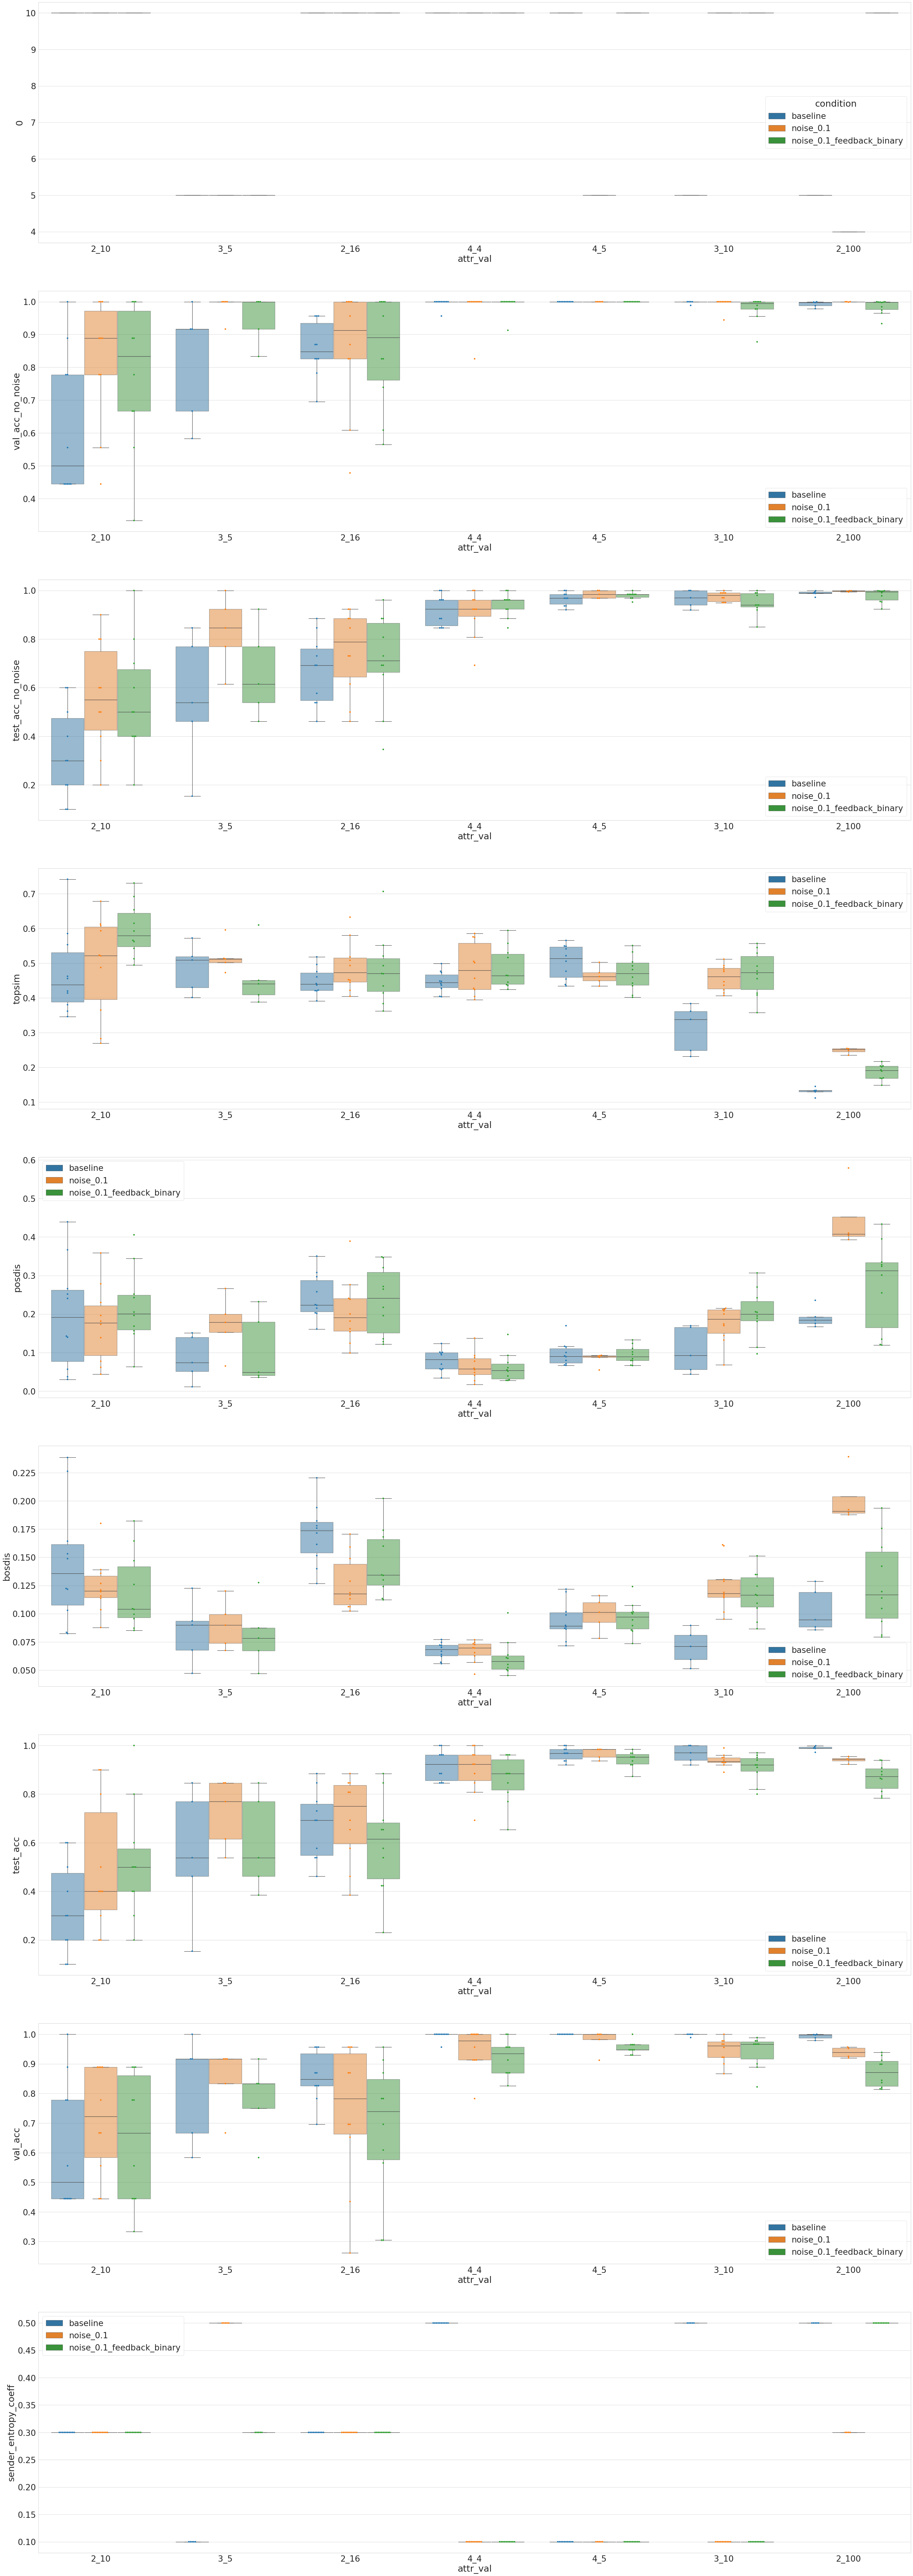

In [6]:


data["condition"] = data["noise"].map(lambda x: f"noise_{x}" if x > 0 else "baseline") + data["length_cost"].map(lambda x: f"_length_cost_{x}" if x > 0 else "") + data["feedback"].map(lambda x: "_feedback" if x else "") + data["open_cr"].map(lambda x: "_binary" if x else "") #+ data["num_agents"].map(lambda x: "_2_agents" if x else "")

# Exclude bad noise setting
target_data = data[~(data.noise == 0.3)]

# TODO: open CR setting
# target_data = target_data[target_data.open_cr == 0]

# TODO: num_agents setting
NUM_AGENTS = 1
target_data = target_data[target_data.num_agents == NUM_AGENTS]


# ATTR_VAL = "4_5"
# target_data = target_data[(target_data["attr_val"] == ATTR_VAL)]

# print(target_data.dir_name.unique())

# hue_order = None
hue_order = ["baseline", "noise_0.1", "noise_0.1_feedback_binary"]
# hue_order = ["baseline", "noise_0.1", "noise_0.1_feedback"]

order = ["2_10", "3_5", "2_16", "4_4", "4_5", "3_10", "2_100"]

target_hparam = "attr_val"

num_runs_data = target_data.groupby(["attr_val", "condition"]).size().reset_index()
# plt.figure(figsize=(30, 10))

_, axes = plt.subplots(9, 1, figsize=(50, 150))

sns.boxplot(ax=axes[0], data=num_runs_data, x="attr_val", order=order, hue="condition", hue_order=hue_order, y=0)

# next_axis_idx = (0, 0)
for i, metric in enumerate(["val_acc_no_noise", "test_acc_no_noise", "topsim", "posdis", "bosdis", "test_acc", "val_acc", "sender_entropy_coeff"]):
    sns.boxplot(ax=axes[i+1], data=target_data, x=target_hparam, y=metric, order=order, hue="condition", hue_order=hue_order, boxprops=dict(alpha=.5), showfliers = False)
    ax = sns.swarmplot(ax=axes[i+1], data=target_data, x=target_hparam, y=metric, order=order, hue="condition", hue_order=hue_order, dodge=True)
    handles, labels = ax.get_legend_handles_labels()
    num_conditions = int(len(handles)/2) if not hue_order else len(hue_order)
    ax.legend(handles[:num_conditions], labels[:num_conditions])
    # plt.setp(ax.get_legend().get_texts(), fontsize='22')
    # if next_axis_idx[1] >= axes.shape[1]-1:
    #     next_axis_idx = (next_axis_idx[0]+1, 0)
    # else:
    #     next_axis_idx = (next_axis_idx[0], next_axis_idx[1]+1)

name = "results"
plt.savefig("plots/"+name+".pdf", dpi=300)

/home/mitja/anaconda3/envs/emergent_communication/lib/python3.9/site-packages/seaborn/categorical.py:1388: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/mitja/anaconda3/envs/emergent_communication/lib/python3.9/site-packages/seaborn/categorical.py:1388: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/mitja/anaconda3/envs/emergent_communication/lib/python3.9/site-packages/seaborn/categorical.py:1388: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/mitja/anaconda3/envs/emergent_communication/lib/python3.9/site-packages/seaborn/categorical.py:1388: FutureWarning: elementwise comparison failed; returning scalar

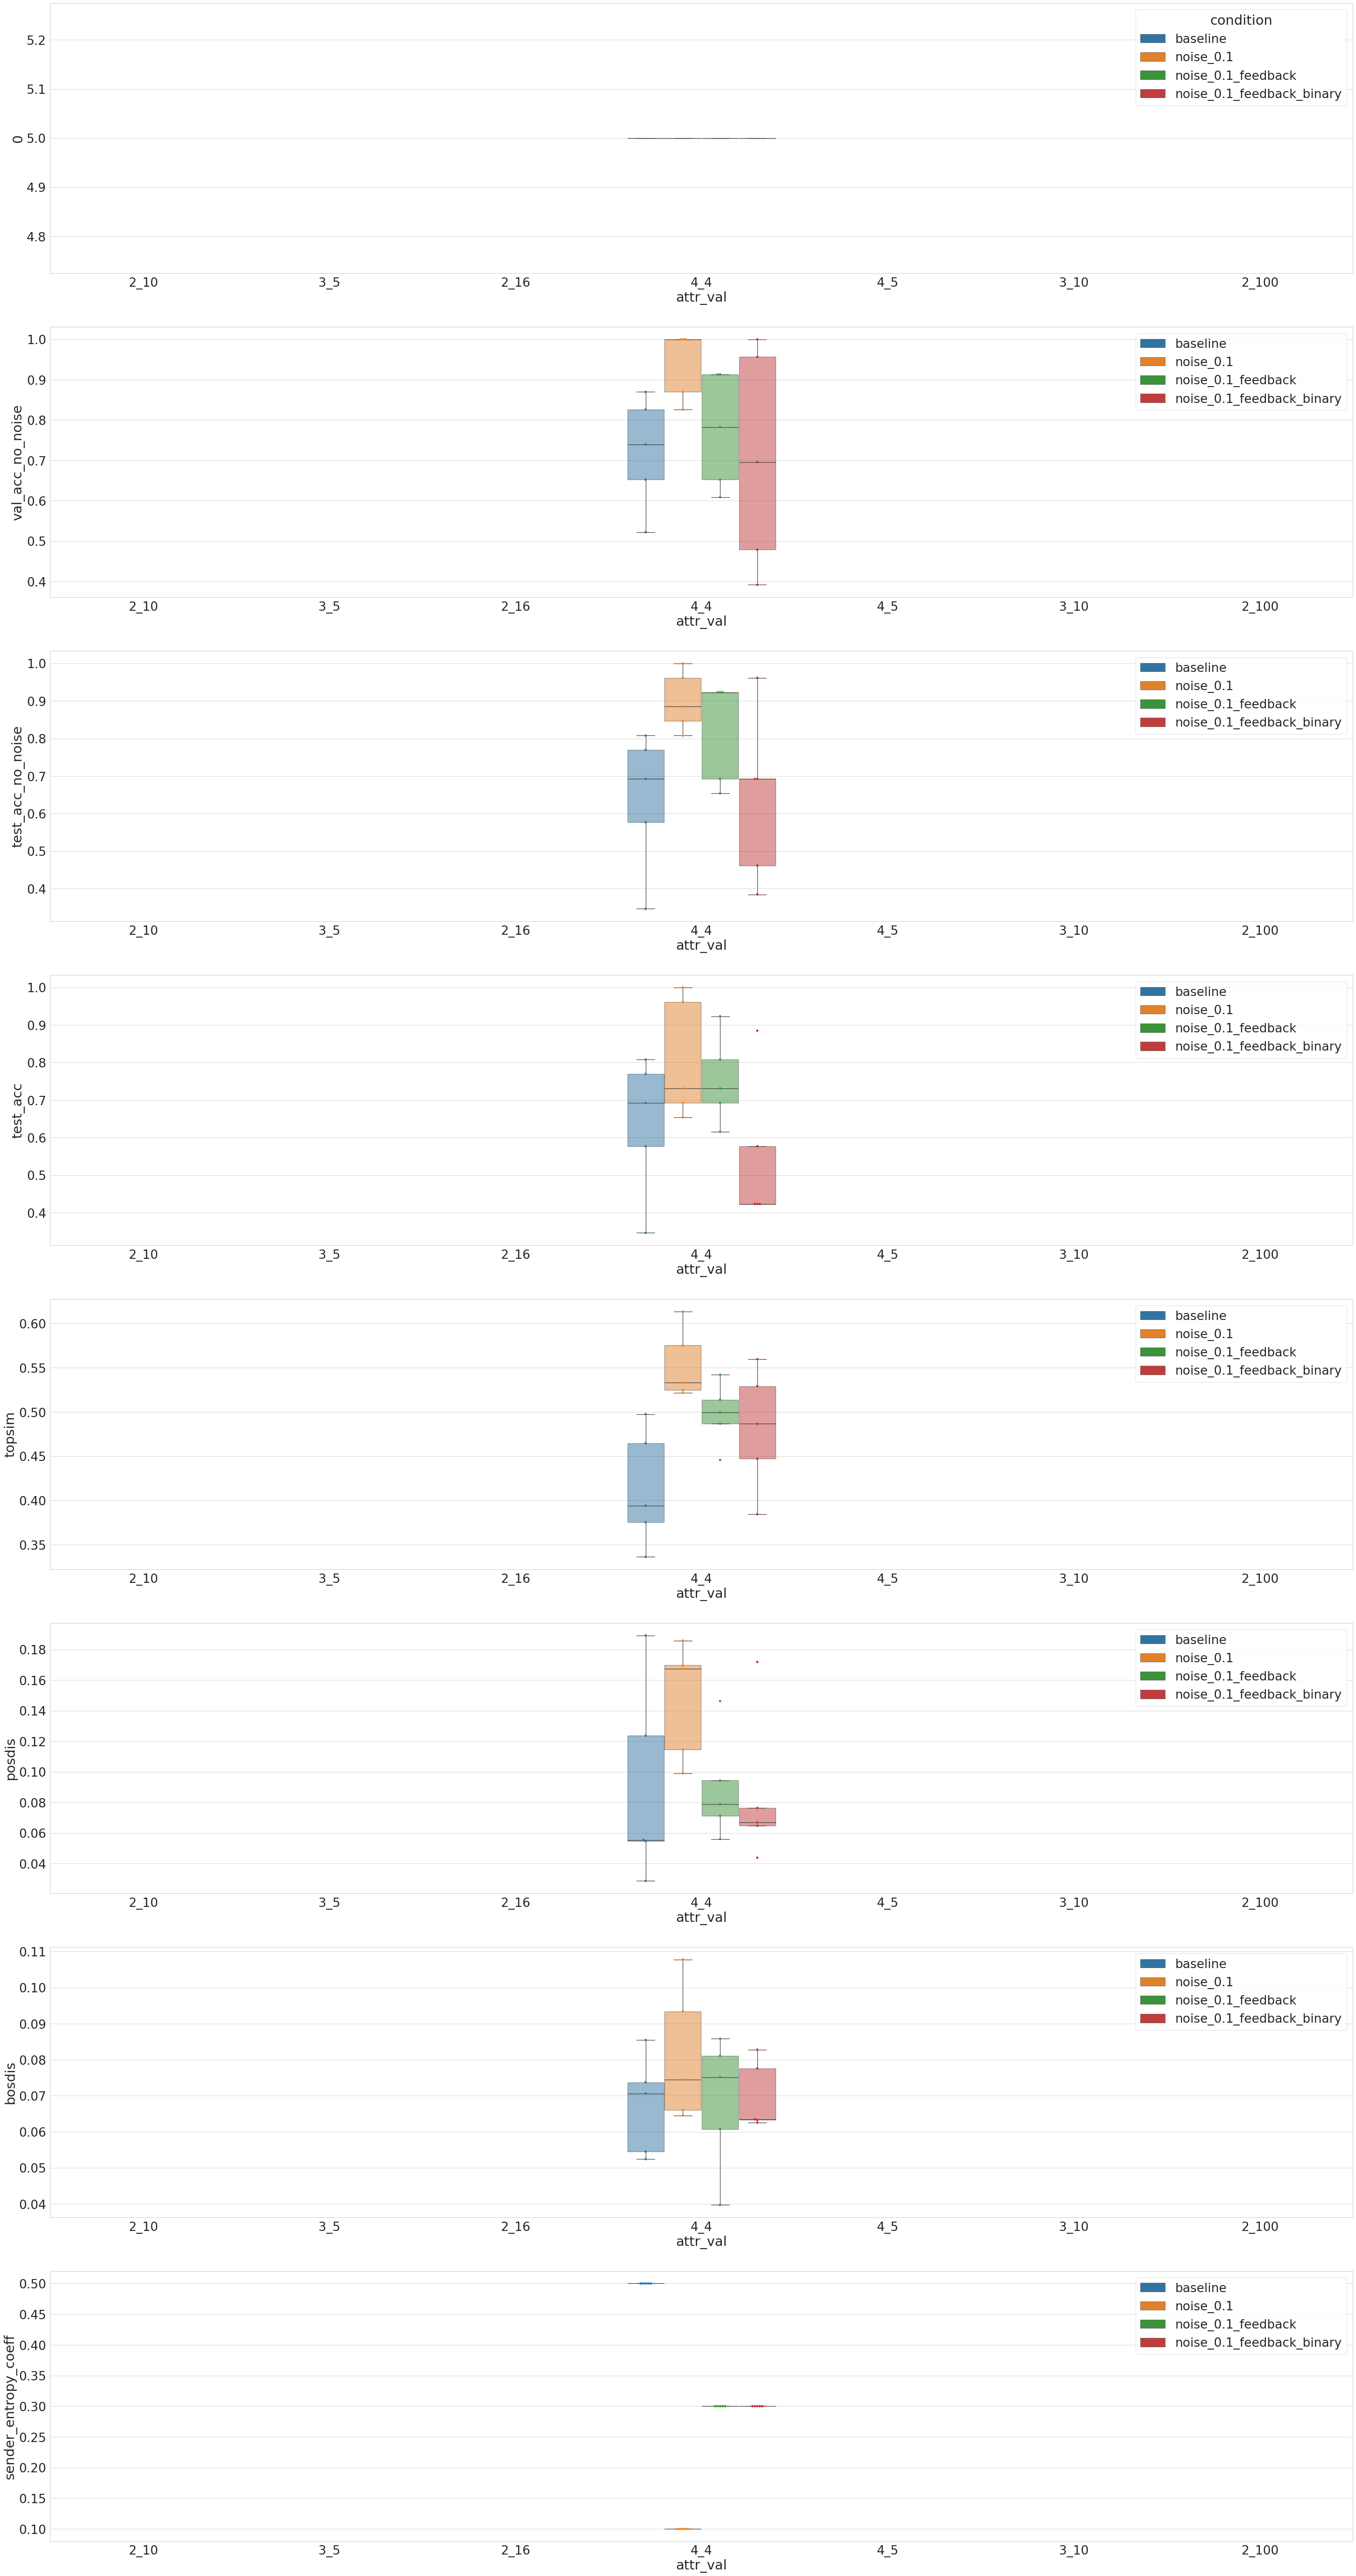

In [4]:


sns.set_context("paper", font_scale=3)


data["condition"] = data["noise"].map(lambda x: f"noise_{x}" if x > 0 else "baseline") + data["length_cost"].map(lambda x: f"_length_cost_{x}" if x > 0 else "") + data["feedback"].map(lambda x: "_feedback" if x else "") + data["open_cr"].map(lambda x: "_binary" if x else "") #+ data["num_agents"].map(lambda x: "_2_agents" if x else "")

# Exclude bad noise setting
target_data = data[~(data.noise == 0.3)]

# TODO: open CR setting
# target_data = target_data[target_data.open_cr == 0]

# TODO: num_agents setting
NUM_AGENTS = 2
target_data = target_data[target_data.num_agents == NUM_AGENTS]


ATTR_VAL = "4_4"
target_data = target_data[(target_data["attr_val"] == ATTR_VAL)]

# print(target_data.dir_name.unique())

# hue_order = None
# hue_order = ["baseline", "noise_0.1", "noise_0.1_length_cost_0.001", "noise_0.1_length_cost_0.001_feedback"]
# hue_order = ["baseline", "noise_0.1", "noise_0.1_feedback_binary"]#, , "noise_0.1_length_cost_0.001_feedback","noise_0.1_length_cost_0.001_feedback"]#, "noise_0.1_length_cost_0.01_feedback"]
hue_order = ["baseline", "noise_0.1", "noise_0.1_feedback", "noise_0.1_feedback_binary"]

order = ["2_10", "3_5", "2_16", "4_4", "4_5", "3_10", "2_100"]

target_hparam = "attr_val"

num_runs_data = target_data.groupby(["attr_val", "condition"]).size().reset_index()
# plt.figure(figsize=(30, 10))

_, axes = plt.subplots(8, 1, figsize=(50, 100))

sns.boxplot(ax=axes[0], data=num_runs_data, x="attr_val", order=order, hue="condition", hue_order=hue_order, y=0)

# next_axis_idx = (0, 0)
for i, metric in enumerate(["val_acc_no_noise", "test_acc_no_noise", "test_acc", "topsim", "posdis", "bosdis", "sender_entropy_coeff"]):
    sns.boxplot(ax=axes[i+1], data=target_data, x=target_hparam, y=metric, order=order, hue="condition", hue_order=hue_order, boxprops=dict(alpha=.5), showfliers = False)
    ax = sns.swarmplot(ax=axes[i+1], data=target_data, x=target_hparam, y=metric, order=order, hue="condition", hue_order=hue_order, dodge=True)
    handles, labels = ax.get_legend_handles_labels()
    num_conditions = int(len(handles)/2) if not hue_order else len(hue_order)
    ax.legend(handles[:num_conditions], labels[:num_conditions])
    # plt.setp(ax.get_legend().get_texts(), fontsize='22')
    # if next_axis_idx[1] >= axes.shape[1]-1:
    #     next_axis_idx = (next_axis_idx[0]+1, 0)
    # else:
    #     next_axis_idx = (next_axis_idx[0], next_axis_idx[1]+1)

name = "results"
plt.savefig("plots/"+name+".pdf", dpi=300)